In [35]:
import os
from torchvision import datasets, transforms

In [36]:
from torch.utils.data import DataLoader

In [37]:
import torch

In [38]:
import torch.nn as nn

In [39]:
import torch.optim as optim

In [40]:
import torch.nn.functional as F

In [41]:
import time

In [42]:
import torchvision.models as models

In [43]:
from matplotlib import pyplot as plt

In [44]:
device = torch.device("cude" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [45]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),    
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
]) 

In [46]:
dataset_path = "./dataset"
dataset = datasets.ImageFolder(root=dataset_path, transform=image_transforms)
len(dataset)

2300

In [47]:
class_names = dataset.classes
class_names

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [48]:
num_classes = len(dataset.classes)
num_classes

6

In [49]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size
train_size, val_size

(1725, 575)

In [50]:
from torch.utils.data import random_split

In [51]:
train_dataset, val_dataset = random_split(dataset, [train_size,val_size])

In [52]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle= True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle= True)

In [53]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [54]:
images[1]

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

In [55]:
labels[1]

tensor(1)

In [56]:
len(images)

32

In [57]:
images[1].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


<function matplotlib.pyplot.show(close=None, block=None)>

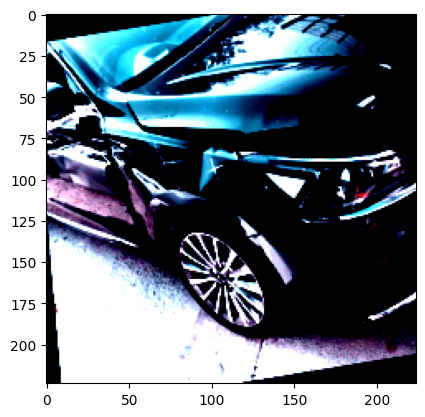

In [58]:
plt.imshow(images[1].permute(1,2,0))
plt.show

In [59]:
# Just for Practice.

# x = torch.tensor([10.0], requires_grad=True)
# y = x**2 + 3*x
# y.backward()
# print(x.grad)  # tensor([7.])  because dy/dx = 2*x + 3 -> at x=2 => 7

In [60]:
class CarClassifierCNN(nn.Module): 
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1 ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)   

        )

    def forward(self, x):
        x = self.network(x)
        return x

In [61]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [ ]:
# Instantiate the model, loss function, and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.78
Batch: 20, Epoch: 1, Loss: 1.73
Batch: 30, Epoch: 1, Loss: 1.67
Batch: 40, Epoch: 1, Loss: 1.54
Batch: 50, Epoch: 1, Loss: 1.52
Epoch [1/10], Avg Loss: 1.9673
*** Validation Accuracy: 41.74% ***
Batch: 10, Epoch: 2, Loss: 1.44
Batch: 20, Epoch: 2, Loss: 1.25
Batch: 30, Epoch: 2, Loss: 1.15
Batch: 40, Epoch: 2, Loss: 1.22
Batch: 50, Epoch: 2, Loss: 1.35
Epoch [2/10], Avg Loss: 1.3599
*** Validation Accuracy: 45.91% ***
Batch: 10, Epoch: 3, Loss: 1.48
Batch: 20, Epoch: 3, Loss: 1.15
Batch: 30, Epoch: 3, Loss: 1.44
Batch: 40, Epoch: 3, Loss: 1.02
Batch: 50, Epoch: 3, Loss: 1.22
Epoch [3/10], Avg Loss: 1.2209
*** Validation Accuracy: 50.61% ***
Batch: 10, Epoch: 4, Loss: 1.06
Batch: 20, Epoch: 4, Loss: 1.34
Batch: 30, Epoch: 4, Loss: 1.15
Batch: 40, Epoch: 4, Loss: 1.30
Batch: 50, Epoch: 4, Loss: 0.87
Epoch [4/10], Avg Loss: 1.1652
*** Validation Accuracy: 53.22% ***
Batch: 10, Epoch: 5, Loss: 1.09
Batch: 20, Epoch: 5, Loss: 0.95
Batch: 30, Epoch: 5, Loss: 0

In [ ]:
model = models.resnet50(weights='DEFAULT')
for name, param in model.named_parameters():
    print(name)


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [ ]:
for name, param in model.named_parameters():
    print(name, param.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

In [ ]:
for name, param in model.named_parameters():
    print(name, param)


conv1.weight Parameter containing:
tensor([[[[-7.4457e-03, -3.1783e-03,  3.7353e-02,  ...,  4.7936e-02,
           -2.0325e-02,  8.8140e-03],
          [-5.7435e-02,  4.4709e-02,  7.7509e-02,  ...,  8.8442e-02,
            2.9346e-02, -5.8331e-02],
          [ 6.8356e-02, -2.7044e-01,  4.0348e-01,  ..., -1.6491e-01,
            2.1868e-01, -7.2909e-02],
          ...,
          [-1.0874e-01,  3.8148e-01, -4.5487e-01,  ...,  6.8366e-01,
           -5.7855e-01,  2.2461e-01],
          [ 2.5698e-02, -1.7703e-01,  6.4375e-01,  ...,  5.2644e-01,
           -4.9317e-02, -6.8082e-02],
          [ 4.5281e-02, -1.3072e-01,  1.7864e-02,  ..., -3.5753e-01,
            1.8976e-01, -2.2302e-02]],

         [[ 8.9197e-03,  4.8768e-03, -1.5356e-02,  ...,  8.6949e-02,
           -6.5541e-02,  1.6895e-02],
          [-3.3543e-02,  3.9067e-02,  8.6565e-02,  ...,  1.1713e-01,
            2.1848e-02, -4.4082e-02],
          [ 5.5285e-02, -2.6424e-01,  4.2687e-01,  ..., -2.3723e-01,
            3.2017e-01,

In [ ]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total parameters:", total)
print("Trainable parameters:", trainable)

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.0.conv3.weight True
layer1.0.bn3.weight True
layer1.0.bn3.bias True
layer1.0.downsample.0.weight True
layer1.0.downsample.1.weight True
layer1.0.downsample.1.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer1.1.conv3.weight True
layer1.1.bn3.weight True
layer1.1.bn3.bias True
layer1.2.conv1.weight True
layer1.2.bn1.weight True
layer1.2.bn1.bias True
layer1.2.conv2.weight True
layer1.2.bn2.weight True
layer1.2.bn2.bias True
layer1.2.conv3.weight True
layer1.2.bn3.weight True
layer1.2.bn3.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.conv3.weight True


In [29]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.36
Batch: 20, Epoch: 1, Loss: 0.95
Batch: 30, Epoch: 1, Loss: 0.71
Batch: 40, Epoch: 1, Loss: 0.71
Batch: 50, Epoch: 1, Loss: 0.63
Epoch [1/10], Avg Loss: 0.9493
*** Validation Accuracy: 47.65% ***
Batch: 10, Epoch: 2, Loss: 0.53
Batch: 20, Epoch: 2, Loss: 0.57
Batch: 30, Epoch: 2, Loss: 0.46
Batch: 40, Epoch: 2, Loss: 0.68
Batch: 50, Epoch: 2, Loss: 0.70
Epoch [2/10], Avg Loss: 0.5670
*** Validation Accuracy: 73.91% ***
Batch: 10, Epoch: 3, Loss: 0.37
Batch: 20, Epoch: 3, Loss: 0.29
Batch: 30, Epoch: 3, Loss: 0.38
Batch: 40, Epoch: 3, Loss: 0.57
Batch: 50, Epoch: 3, Loss: 0.34
Epoch [3/10], Avg Loss: 0.4100
*** Validation Accuracy: 79.48% ***
Batch: 10, Epoch: 4, Loss: 0.39
Batch: 20, Epoch: 4, Loss: 0.24
Batch: 30, Epoch: 4, Loss: 0.95
Batch: 40, Epoch: 4, Loss: 0.50
Batch: 50, Epoch: 4, Loss: 0.32
Epoch [4/10], Avg Loss: 0.3277
*** Validation Accuracy: 76.35% ***
Batch: 10, Epoch: 5, Loss: 0.09
Batch: 20, Epoch: 5, Loss: 0.20
Batch: 30, Epoch: 5, Loss: 0

In [30]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       125
           1       0.75      0.81      0.78        95
           2       0.88      0.88      0.88       121
           3       0.85      0.61      0.71        76
           4       0.66      0.77      0.71        74
           5       0.80      0.85      0.82        84

    accuracy                           0.81       575
   macro avg       0.80      0.79      0.79       575
weighted avg       0.81      0.81      0.80       575



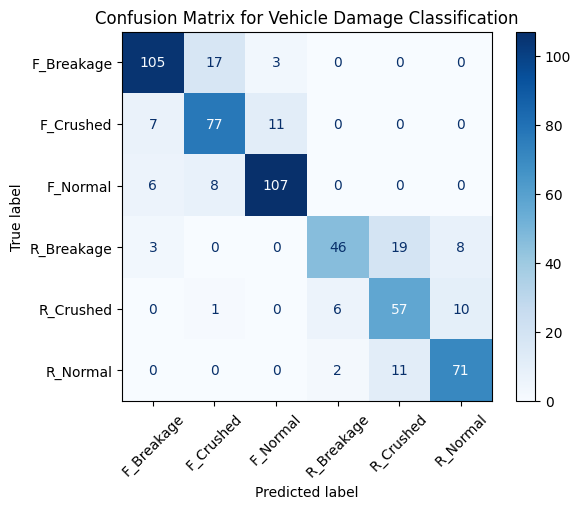

In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

In [35]:
torch.save(model.state_dict(), 'saved_model.pth')